# With Valid Stocks and 2 years of data, Sector Consumer Defensive

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from mymodule.DatabaseConnection import CRUD
from dotenv import load_dotenv
load_dotenv()

from sklearn.preprocessing import LabelEncoder

In [2]:
import importlib
import mymodule.DatabaseConnection  # first import
importlib.reload(mymodule.DatabaseConnection) 

<module 'mymodule.DatabaseConnection' from 'c:\\Projects\\Market\\mymodule\\DatabaseConnection.py'>

In [3]:
def add_rolling_mean(df: pd.DataFrame,*days: int) -> pd.DataFrame:
    for day in days:
        df[str(day)+'DMA'] = df['close'].rolling(day).mean()
    return df

In [4]:
def convert_to_numeric(df):
    features = ['open', 'high', 'low', 'close', 'volume' ]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    le = LabelEncoder()
    ISIN = le.fit_transform(df['ISIN'])
    
    scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)
    scaled_df['ISIN'] = ISIN

    return scaled_df

In [5]:
lo_stock = CRUD('v_stockdailyupdate')
df_stocks = lo_stock.Read()
df_stocks.dropna(subset=['SectorId'],inplace=True)
df_stocks = df_stocks[df_stocks['BlackListed'].isna()]
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])

df_stocks = df_stocks.sort_values('Date')

df_stocks = df_stocks[df_stocks['Date'] >= '20231201']
df_stocks = df_stocks[df_stocks['Date'] < '20251201']

In [6]:
df_count = pd.DataFrame(data=df_stocks[df_stocks['Date'] >= '20231201']['ISIN'].value_counts().reset_index())
df_count.columns = ['ISIN', 'COUNT']
df_valid = df_count[df_count['COUNT']==493]
df_stocks = df_stocks.merge(df_valid, how='inner', on='ISIN')

df_stocks = df_stocks.sort_values(by=['ISIN','Date']).reset_index()
df_stocks = df_stocks[['Date','ISIN','SectorId','open','high','low','close','volume']]

In [7]:
df_stocks['SectorId'] = df_stocks['SectorId'].astype('int')

In [8]:
df_stocks['ISIN'].value_counts()

ISIN
IN9175A01010    493
IN9623B01058    493
INE001B01026    493
INE002A01018    493
INE002L01015    493
               ... 
INE998H01012    493
INE998I01010    493
INE999A01023    493
INE999B01013    493
INE999K01014    493
Name: count, Length: 1813, dtype: int64

In [9]:
def generate_series(scaled_df,lookback=60):
    X, y = [], []
    for a in range(1813):
        print('Stock : ',a+1)
        scaled_df1 = scaled_df[a*493:(a+1)*493]
        scaled_df1.reset_index(inplace=True)
        for i in range(lookback, len(scaled_df1)):
            X.append(scaled_df1.iloc[i-lookback:i].values)
            y.append(scaled_df1.iloc[i]['close'])

    X, y = np.array(X), np.array(y)
    return X, y

In [10]:
features = ['open', 'high', 'low', 'close', 'volume' ]

#for sector in sectors:
df_stocks1 = df_stocks[df_stocks['SectorId'] == 4 ]
df_stocks1.reset_index(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_stocks1[features])

le = LabelEncoder()
ISIN = le.fit_transform(df_stocks1['ISIN'])

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_stocks1.index)
scaled_df['ISIN'] = ISIN

In [11]:
lookback = 60
X, y = [], []
for a in range(scaled_df['ISIN'].nunique()):
    print('Stock : ',a+1)
    scaled_df1 = scaled_df[a*493:(a+1)*493]
    scaled_df1.reset_index(inplace=True)
    scaled_df1 = scaled_df1.drop(columns=['index'],axis=1)
    for i in range(lookback, len(scaled_df1)):
        X.append(scaled_df1.iloc[i-lookback:i].values)
        y.append(scaled_df1.iloc[i]['close'])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # (samples, timesteps=60, features)
print("y shape:", y.shape)  # (samples,)

Stock :  1
Stock :  2
Stock :  3
Stock :  4
Stock :  5
Stock :  6
Stock :  7
Stock :  8
Stock :  9
Stock :  10
Stock :  11
Stock :  12
Stock :  13
Stock :  14
Stock :  15
Stock :  16
Stock :  17
Stock :  18
Stock :  19
Stock :  20
Stock :  21
Stock :  22
Stock :  23
Stock :  24
Stock :  25
Stock :  26
Stock :  27
Stock :  28
Stock :  29
Stock :  30
Stock :  31
Stock :  32
Stock :  33
Stock :  34
Stock :  35
Stock :  36
Stock :  37
Stock :  38
Stock :  39
Stock :  40
Stock :  41
Stock :  42
Stock :  43
Stock :  44
Stock :  45
Stock :  46
Stock :  47
Stock :  48
Stock :  49
Stock :  50
Stock :  51
Stock :  52
Stock :  53
Stock :  54
Stock :  55
Stock :  56
Stock :  57
Stock :  58
Stock :  59
Stock :  60
Stock :  61
Stock :  62
Stock :  63
Stock :  64
Stock :  65
Stock :  66
Stock :  67
Stock :  68
Stock :  69
Stock :  70
Stock :  71
Stock :  72
Stock :  73
Stock :  74
Stock :  75
Stock :  76
Stock :  77
Stock :  78
Stock :  79
Stock :  80
Stock :  81
Stock :  82
Stock :  83
Stock :  84
S

In [12]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class PositionalEncoding(Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        self.sequence_len = sequence_len
        self.d_model = d_model

    def call(self, x):
        position = tf.range(self.sequence_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, self.d_model, 2, dtype=tf.float32) *
            (-tf.math.log(10000.0) / self.d_model)
        )

        pe = tf.zeros((self.sequence_len, self.d_model))
        pe_even = tf.sin(position * div_term)
        pe_odd = tf.cos(position * div_term)

        pe = tf.reshape(
            tf.stack([pe_even, pe_odd], axis=2),
            (self.sequence_len, self.d_model)
        )

        pe = pe[tf.newaxis, ...]
        return x + pe[:, :tf.shape(x)[1], :]

In [14]:
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention
)

class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D

sequence_length = X_train.shape[1]
feature_dim = X_train.shape[2]
embed_dim = 64
num_heads = 4
ff_dim = 128

inputs = Input(shape=(sequence_length, feature_dim))
x = Dense(embed_dim)(inputs)
x = PositionalEncoding(sequence_length, embed_dim)(x)
x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)
x = Dropout(0.2)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)  # Regression output

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 60, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 60, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,705 (330.88 KB)

 Trainable params: 84,705 (330.88 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - loss: 0.0077 - val_loss: 6.1676e-04
Epoch 2/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 6.3262e-04 - val_loss: 3.1756e-04
Epoch 3/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 3.7738e-04 - val_loss: 7.3539e-04
Epoch 4/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 2.8966e-04 - val_loss: 7.8501e-04
Epoch 5/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 2.2778e-04 - val_loss: 2.3220e-04
Epoch 6/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 1.8391e-04 - val_loss: 1.3039e-04
Epoch 7/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - loss: 1.9092e-04 - val_loss: 1.6282e-04
Epoch 8/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - loss: 1.9121e-04 - val_loss: 7.5637e-05
Epoch 9/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - loss: 1.5599e-04 - val_loss: 1.0090e-04
Epoch 10/100
1316/1316 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - loss: 1.0546e-04 - val_loss: 4.6095e-04
Epoch 11/100


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


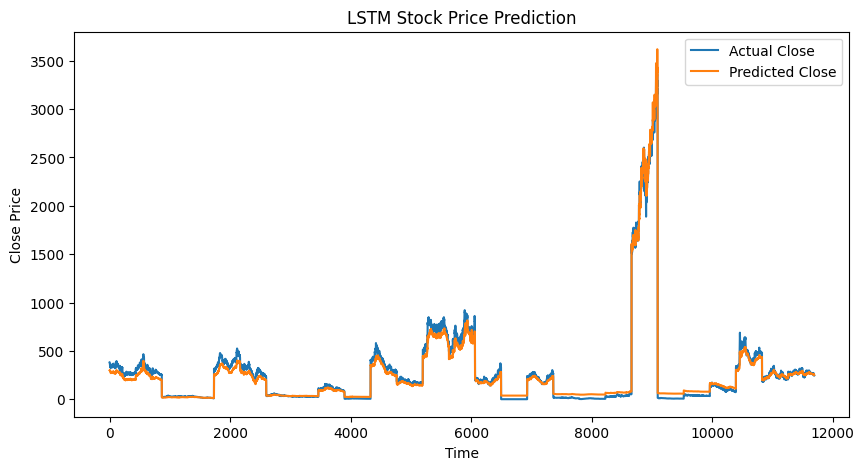

In [17]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 2310.6503
RMSE: 48.0692
MAE : 37.0705
R²  : 0.9887
